In [7]:
import os
import pandas as pd
import numpy as np
import pycaret.classification as pc

import matplotlib.pyplot as plt

import mlflow
from mlflow.models.signature import infer_signature
from mlflow.tracking import MlflowClient

os.environ["GIT_PYTHON_REFRESH"] = "quiet"

In [8]:
#Configuração MLFLOW
# Para usar o sqlite como repositorio
mlflow.set_tracking_uri("sqlite:///mlruns.db")

experiment_name = 'Projeto Kobe'
experiment = mlflow.get_experiment_by_name(experiment_name)
if experiment is None:
    experiment_id = mlflow.create_experiment(experiment_name)
    experiment = mlflow.get_experiment(experiment_id)
experiment_id = experiment.experiment_id

In [23]:
from sklearn.model_selection import train_test_split


data_cols = ['lat','lon', 'minutes_remaining','period', 'playoffs','shot_distance','shot_made_flag']
train_perc = 0.8


with mlflow.start_run(experiment_id=experiment_id, run_name = 'PreparacaoDados'):
    
    df_dev = pd.read_parquet("D:\\repositorios\\kobe-dataset\\data\\raw\\dataset_kobe_dev.parquet")
    df_dev = df_dev[data_cols].copy()
    df_dev.dropna(inplace=True)
    
    df_dev.to_parquet("D:\\repositorios\\kobe-dataset\\data\\processed\\data_filtered.parquet")
    
    xtrain, xtest, ytrain, ytest = train_test_split(df_dev[['lat','lon', 'minutes_remaining','period', 'playoffs','shot_distance']],
                                                    df_dev['shot_made_flag'],                                                
                                                    train_size=train_perc,
                                                    stratify=df_dev['shot_made_flag'])    
    xtrain['shot_distance'] = ytrain
    xtest['shot_distance'] = ytest
    xtrain.to_parquet('D:\\repositorios\\kobe-dataset\\data\\processed\\base_train.parquet')
    xtest.to_parquet('D:\\repositorios\\kobe-dataset\\data\\processed\\base_test.parquet')

    mlflow.log_params({
        'perc-teste': 1-train_perc,
        'colunas-selecionadas': data_cols
    })
    mlflow.log_metrics({
        'qtd_linhas_treino': xtrain.shape[0],
        'qtd_linhas_teste': xtest.shape[0],
    })

In [10]:
#Treinando o modelo
from sklearn.model_selection import validation_curve


def plot_parameter_validation_curve(X, Y, param_name, grid_search,
                                    model, model_name, scoring,
                                    logx):
    print('Parameter:', param_name)
    print('GridSearch:', grid_search[param_name])
    print('Scoring:', scoring)
    plt.figure(figsize=(6,4))
    train_scores, test_scores = validation_curve(model,
                                                 X = X, 
                                                 y = Y, 
                                                 param_name=param_name, 
                                                 param_range= grid_search[param_name],
                                                 scoring=scoring,
                                                 cv=10,
                                                 n_jobs=-1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.title("Curva Validação Modelo " + model_name)
    plt.xlabel(param_name)
    plt.ylabel("Score ("+scoring+")")
    if logx:
        plt.semilogx(grid_search[param_name], train_scores_mean,'-o', label="Treino",
                     color="darkorange", lw=2)
        plt.semilogx(grid_search[param_name], test_scores_mean,'-o', label="Validação-Cruzada",
                     color="navy", lw=2)
    else:
        plt.plot(grid_search[param_name], train_scores_mean,'-o', label="Treino",
                     color="darkorange", lw=2)
        plt.plot(grid_search[param_name], test_scores_mean,'-o', label="Validação-Cruzada",
                 color="navy", lw=2)
    plt.fill_between(grid_search[param_name], train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=2)
    plt.fill_between(grid_search[param_name], test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=2)
    plt.legend(loc='best')
    plt.grid(True)
    return plt.gcf()

In [11]:
mlflow.end_run()

,Description,Value
0,Session id,6470
1,Target,shot_distance
2,Target type,Binary
3,Original data shape,"(20285, 6)"
4,Transformed data shape,"(20285, 6)"
5,Transformed train set shape,"(16228, 6)"
6,Transformed test set shape,"(4057, 6)"
7,Numeric features,5
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,0.5460,0.5022,0.5942,0.5215,0.5554,0.0957,0.0965,0.1920
lr,Logistic Regression,0.5588,0.5688,0.5108,0.5401,0.5250,0.1138,0.1140,0.2830


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.5482,0.5525,0.5070,0.5280,0.5173,0.0930,0.0930


Parameter: C
GridSearch: [0.001, 0.01, 0.1, 1, 10]
Scoring: f1


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Decision Tree Classifier,0.5309,0.5132,0.5880,0.5076,0.5448,0.0663,0.0671


Parameter: max_depth
GridSearch: [2, 3, 4, 5, 6, 7, 8]
Scoring: f1


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.5336,0.4815,0.0606,0.6184,0.1105,0.0275,0.0625
1,0.5274,0.5000,0.0245,0.6333,0.0472,0.0120,0.0428
2,0.5219,0.4944,0.0310,0.4898,0.0583,0.0015,0.0043
3,0.5243,0.4969,0.0374,0.5273,0.0699,0.0070,0.0187
4,0.5280,0.4992,0.0477,0.5692,0.0881,0.0153,0.0375
5,0.5225,0.5023,0.0387,0.5000,0.0719,0.0035,0.0088
6,0.5305,0.4780,0.0465,0.6000,0.0863,0.0190,0.0483
7,0.5274,0.5048,0.0413,0.5614,0.0770,0.0124,0.0323
8,0.5314,0.5006,0.0362,0.6667,0.0686,0.0205,0.0618


Fitting 10 folds for each of 4 candidates, totalling 40 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Decision Tree Classifier,0.5309,0.5132,0.5880,0.5076,0.5448,0.0663,0.0671


Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Loaded


Registered model 'model_kobe' already exists. Creating a new version of this model...
Created version '4' of model 'model_kobe'.


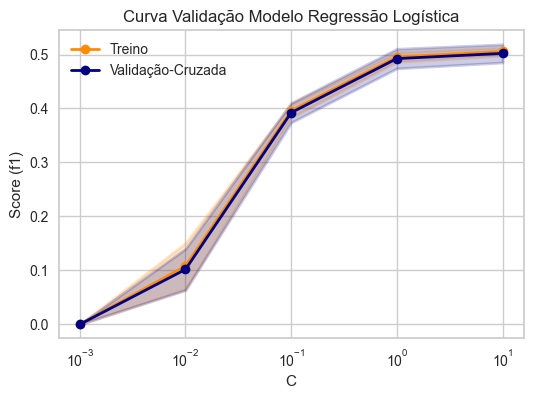

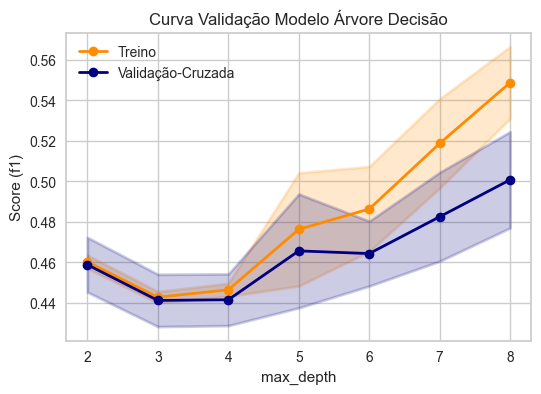

In [12]:
import os
from sklearn.metrics import log_loss, f1_score

registered_model_name = 'model_kobe'
nexamples = 5
model_version = -1

with mlflow.start_run(experiment_id=experiment_id, run_name = 'Treinamento'):
  
    exp = pc.setup(
        data=xtrain,
        target = 'shot_distance',
        test_data = xtest,
        normalize=True,
        log_experiment = False
    )
    list_models = exp.compare_models(['lr','dt'], n_select=2, sort='f1')

    # REGRESSAO
    # exp.plot_model(list_models[0], plot='vc', save = True)
    yhat_test = exp.predict_model(list_models[1])
    plot_parameter_validation_curve(xtrain.drop('shot_distance', axis=1), ytrain, 'C', {'C': [0.001, 0.01, 0.1, 1, 10]},
                                        list_models[1], 'Regressão Logística', 'f1', logx=True)
    plt.savefig('lr_validation_curve.png')
    mlflow.log_artifact('lr_validation_curve.png')
    # os.remove('lr_validation_curve.png')
    
    mlflow.log_metrics({
        'lr_log_loss': log_loss(yhat_test.shot_distance, yhat_test.prediction_label),
        'lr_f1': f1_score(yhat_test.shot_distance, yhat_test.prediction_label),
    })
    
    # ARVORE
    yhat_test = exp.predict_model(list_models[0])
    plot_parameter_validation_curve(xtrain.drop('shot_distance', axis=1), ytrain, 'max_depth', {'max_depth': [2, 3, 4, 5, 6, 7, 8]},
                                    list_models[0], 'Árvore Decisão', 'f1', logx=False)
    plt.savefig('dt_validation_curve.png')
    mlflow.log_artifact('dt_validation_curve.png')
    # os.remove('dt_validation_curve.png')

    mlflow.log_metrics({
        'dt_log_loss': log_loss(yhat_test.shot_distance, yhat_test.prediction_label),
        'dt_f1': f1_score(yhat_test.shot_distance, yhat_test.prediction_label),
    })
    
     # FINALIZACAO MELHOR MODELO
    tune_model = exp.tune_model(list_models[0],
                                optimize = 'f1',
                                search_library = 'scikit-learn',
                                search_algorithm = 'random',
                                n_iter = 4)
    yhat_test = exp.predict_model(tune_model, raw_score=True)  
    mlflow.log_metrics({
        'final_model_log_loss': log_loss(yhat_test.shot_distance, yhat_test.prediction_label),
        'final_model_f1': f1_score(yhat_test.shot_distance, yhat_test.prediction_label),
    })
    yhat_test.to_parquet('D:\\repositorios\\kobe-dataset\\data\\processed\\prediction_test.parquet')
    mlflow.log_artifact('D:\\repositorios\\kobe-dataset\\data\\processed\\prediction_test.parquet')
    
    final_model = exp.finalize_model(tune_model)
    
    # EXPORTACAO PARA LOG E REGISTRO DO MODELO
    exp.save_model(final_model, f'./{registered_model_name}') 
    # Carrega novamente o pipeline + bestmodel
    model_pipe = exp.load_model(f'./{registered_model_name}')
    # Assinatura do Modelo Inferida pelo MLFlow
    model_features = list(xtrain.drop('shot_distance', axis=1).columns)
    inf_signature = infer_signature(xtrain[model_features], 
                                    model_pipe.predict_proba(xtrain.drop('shot_distance', axis=1)))
    # Exemplo de entrada para o MLmodel
    input_example = {x: xtrain[x].values[:nexamples] for x in model_features}
    # Log do pipeline de modelagem do sklearn e registrar como uma nova versao
    mlflow.sklearn.log_model(
        sk_model=model_pipe,
        artifact_path="sklearn-model",
        registered_model_name=registered_model_name,
        signature = inf_signature,
        input_example = input_example,
        pyfunc_predict_fn='predict_proba'
    )
    # Criacao do cliente do servico MLFlow e atualizacao versao modelo
    client = MlflowClient()
    if model_version == -1:
        model_version = client.get_latest_versions(registered_model_name)[-1].version
    # Registrar o modelo como staging
    client.set_registered_model_alias(
        name    = registered_model_name, 
        alias   = "staging", 
        version = model_version
    )